# 06MBIG - Machine Learning  
## Álvaro González Rodríguez  
### 74746657S

En este notebook se pretende devolver una solución al problema de la competición del Dengue de DrivenData.
(https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).  
El objetivo es predecir los casos totales de dengue en los días especificados en el dataset *dengue_features_test.csv*.  
La puntuación mínima que debemos obtener es de MAE = 29.2764

---
# Actividad 2 - Predicción

En esta actividad usaremos los datos preprocesados de la actividad anterior para crear modelos de Machine Learning visto en clase y predecir los casos totales de Dengue del dataset de test.

Lo primero que haremos será cargar los datos preperocesados guardados.

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [5]:
# Cargamos los datos de la actividad 1
train = pd.read_csv('dengue_train.csv')
test = pd.read_csv('dengue_test.csv')

El siguiente paso que tenemos que hacer es separar la variable independiente de las dependientes.
Hecho esto, preprocesamos nuestros datos mediante el transformardor `MinMaxScaler()` de Scikit-Learn para reajustar nuestros datos al intervalo (0,1).

In [6]:
# Definimos dataset de Train, Test y separamos en variables dependientes e independiente.
X_train = train.drop('total_cases', axis=1)
X_test = test
y_train = train['total_cases']

# Definimos transformador
transformer = MinMaxScaler(feature_range=[0,1]).fit(X_train)

# # Normalizamos los datos:
X_train_norm = transformer.transform(X_train)
X_test_norm = transformer.transform(X_test)

### PCA - Reducción de dimensionalidad  

Realizamos un algoritmo de reducción de dimensionalidad para evitar usar más variables de las debidas. Buscamos un número de componentes principales alto, tal que explique de manera adecuada la varianza de nuestros datos. En la actividad anterior vimos que un número de 4 componentes principales nos explicaba un 96.68% de varianza, nos quedaremos con ese valor.

In [7]:
# Definimos transformador PCA con 4 componentes
pca = PCA(n_components=4)

# # Reducimos dimensionalidad
X_train_norm_pca = pca.fit_transform(X_train_norm)
X_test_norm_pca = pca.transform(X_test_norm)

Ahora que tenemos nuestros datos preprocesados, el siguiente paso será decidir qué modelos de regresión usaremos para predecir los casos de Dengue.  

Los modelos que escogeremos serán:
- `LinearRegression`
- `RandomForestRegressor`
- `KNeighborsRegressor`

todos ellos de la librería Scikit-Learn.

In [8]:
Kfold_splits = 5
pca = PCA(n_components=4)

# Dividiremos el conjunto de Train en subtrain y subtest 10 veces (aleatoriamente)
cv = TimeSeriesSplit(n_splits=5)

cv = KFold(n_splits=Kfold_splits, 
           shuffle=False)

## Linear Regression

In [9]:
# Definimos el modelo a usar
model = LinearRegression()

list_mae_test = []
list_mae_train = []
for subtrain, subtest in cv.split(train):
        
    # Dividimos nuestro dataset de train en dos subconjuntos
    # para entrenar y evaluar nuestros modelos
    X_subtrain = train.loc[subtrain]
    y_subtrain = train.loc[subtrain]['total_cases']
    X_subtest = train.loc[subtest]
    y_subtest = train.loc[subtest]['total_cases']

    # Definimos transformador
    transformer = MinMaxScaler(feature_range=[0,1]).fit(X_subtrain)
    # Normalizamos los datos:
    X_subtrain_norm = transformer.transform(X_subtrain)
    X_subtest_norm = transformer.transform(X_subtest)

    # Reducimos dimensionalidad
    X_subtrain_norm_pca = pca.fit_transform(X_subtrain_norm)
    X_subtest_norm_pca = pca.transform(X_subtest_norm)

    # Entrenamos modelo con conjunto subtrain
    model.fit(X = X_subtrain_norm_pca,
                y = y_subtrain)
    
    # Predecimos con el modelo entrenado
    pred_test = model.predict(X = X_subtest_norm_pca)
    pred_train = model.predict(X = X_subtrain_norm_pca)

    # Evaluamos modelo
    mae_test = mean_absolute_error(y_subtest, pred_test)
    mae_train = mean_absolute_error(y_subtrain, pred_train)

    # Guardamos el valor del MAE para luego hacer la media
    list_mae_test.append(mae_test)
    list_mae_train.append(mae_train)

# Calculamos la media del MAE    
total_scores_test = sum(list_mae_test)/len(list_mae_test)
total_scores_train = sum(list_mae_train)/len(list_mae_train)

print('Test Average MAE: ', total_scores_test)
print('Train Average MAE: ', total_scores_train)

Test Average MAE:  27.393241906410395
Train Average MAE:  20.1212322585171


In [10]:
# Definimos el modelo
model = LinearRegression()

# Modelo con 4 variables
model.fit(X_train_norm_pca, y_train)

# Hacemos predicciones sobre el test
predictions = (model.predict(X_test_norm_pca)).astype('int')

# Convertimos a 0 los valores negativos
predictions[predictions<0] = 0

# Guardamos los resultados en un DataFrame
results = pd.read_csv('./dengue_features_test.csv', usecols=['city', 'year', 'weekofyear'])
results['total_cases'] = predictions

results.to_csv('LinearRegression_results.csv', index=False)

## Random Forest Regressor

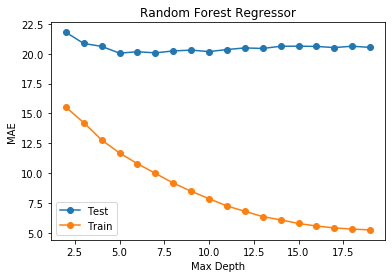

In [11]:
parameters = range(2,20,1)
total_scores_test = []
total_scores_train = []
for estimator in parameters:

    list_mae_test = []
    list_mae_train = []

    # Definimos el modelo a usar
    model = RandomForestRegressor(n_estimators=20, 
                                  criterion='mae',
                                  max_depth=estimator,
                                  n_jobs=-1,
                                  random_state=23)
    for subtrain, subtest in cv.split(train):
            
        # Dividimos nuestro dataset de train en dos subconjuntos
        # para entrenar y evaluar nuestros modelos
        X_subtrain = train.loc[subtrain]
        y_subtrain = train.loc[subtrain]['total_cases']
        X_subtest = train.loc[subtest]
        y_subtest = train.loc[subtest]['total_cases']

        # Definimos transformador
        transformer = MinMaxScaler(feature_range=[0,1]).fit(X_subtrain)
        # Normalizamos los datos:
        X_subtrain_norm = transformer.transform(X_subtrain)
        X_subtest_norm = transformer.transform(X_subtest)

        # Reducimos dimensionalidad
        X_subtrain_norm_pca = pca.fit_transform(X_subtrain_norm)
        X_subtest_norm_pca = pca.transform(X_subtest_norm)

        # Entrenamos modelo con conjunto subtrain
        model.fit(X = X_subtrain_norm_pca,
                  y = y_subtrain)
        
        # Predecimos con el modelo entrenado
        pred_test = model.predict(X = X_subtest_norm_pca)
        pred_train = model.predict(X = X_subtrain_norm_pca)

        # Evaluamos modelo
        mae_test = mean_absolute_error(y_subtest, pred_test)
        mae_train = mean_absolute_error(y_subtrain, pred_train)

        list_mae_test.append(mae_test)
        list_mae_train.append(mae_train)

    total_scores_test.append(sum(list_mae_test)/len(list_mae_test))
    total_scores_train.append(sum(list_mae_train)/len(list_mae_train))


plt.plot(parameters, total_scores_test, marker='o', label='Test')
plt.plot(parameters, total_scores_train, marker='o', label='Train')
plt.title('Random Forest Regressor')
plt.ylabel('MAE') 
plt.xlabel('Max Depth') 
plt.legend()
plt.show() 

In [12]:
# Definimos el modelo
model = RandomForestRegressor(max_depth=5)
# Modelo con 4 variables
model.fit(X_train_norm_pca, y_train)

# Hacemos predicciones sobre el test
predictions = (model.predict(X_test_norm_pca)).astype('int')

# Convertimos a 0 los valores negativos
predictions[predictions<0] = 0

# Guardamos los resultados en un DataFrame
results = pd.read_csv('./dengue_features_test.csv', usecols=['city', 'year', 'weekofyear'])
results['total_cases'] = predictions

# results.to_csv('RandomForestRegressor_results.csv', index=False)

## KNeighbors Regressor

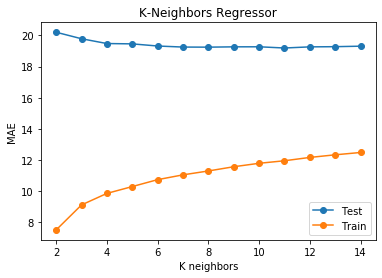

In [14]:
parameters = range(2,15,1)
total_scores_test = []
total_scores_train = []
for estimator in parameters:

    list_mae_test = []
    list_mae_train = []

    model = KNeighborsRegressor(n_neighbors=estimator, weights='uniform')
    for subtrain, subtest in cv.split(train):
            
        # Dividimos nuestro dataset de train en dos subconjuntos
        # para entrenar y evaluar nuestros modelos
        X_subtrain = train.loc[subtrain]
        y_subtrain = train.loc[subtrain]['total_cases']
        X_subtest = train.loc[subtest]
        y_subtest = train.loc[subtest]['total_cases']

        # Definimos transformador
        transformer = MinMaxScaler(feature_range=[0,1]).fit(X_subtrain)
        # Normalizamos los datos:
        X_subtrain_norm = transformer.transform(X_subtrain)
        X_subtest_norm = transformer.transform(X_subtest)

        # Reducimos dimensionalidad
        X_subtrain_norm_pca = pca.fit_transform(X_subtrain_norm)
        X_subtest_norm_pca = pca.transform(X_subtest_norm)

        # Entrenamos modelo con conjunto subtrain
        model.fit(X = X_subtrain_norm_pca,
                  y = y_subtrain)
        
        # Predecimos con el modelo entrenado
        pred_test = model.predict(X = X_subtest_norm_pca)
        pred_train = model.predict(X = X_subtrain_norm_pca)

        # Evaluamos modelo
        mae_test = mean_absolute_error(y_subtest, pred_test)
        mae_train = mean_absolute_error(y_subtrain, pred_train)

        list_mae_test.append(mae_test)
        list_mae_train.append(mae_train)

    total_scores_test.append(sum(list_mae_test)/len(list_mae_test))
    total_scores_train.append(sum(list_mae_train)/len(list_mae_train))


plt.plot(parameters, total_scores_test, marker='o', label='Test')
plt.plot(parameters, total_scores_train, marker='o', label='Train')
plt.title('K-Neighbors Regressor')
plt.ylabel('MAE')
plt.xlabel('K neighbors')
plt.legend()
plt.show()

In [15]:
# Definimos el modelo
model = KNeighborsRegressor(n_neighbors=4)
# Modelo con 4 variables
model.fit(X_train_norm_pca, y_train)

# Hacemos predicciones sobre el test
predictions = (model.predict(X_test_norm_pca)).astype('int')

# Convertimos a 0 los valores negativos
predictions[predictions<0] = 0

# Guardamos los resultados en un DataFrame
results = pd.read_csv('./dengue_features_test.csv', usecols=['city', 'year', 'weekofyear'])
results['total_cases'] = predictions

results.to_csv('KNeighborsRegressor_results.csv', index=False)